In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler 
from sklearn.metrics import accuracy_score, classification_report, RocCurveDisplay, confusion_matrix, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.utils import shuffle, resample
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt 
import seaborn as sns

import warnings

## Project Info
Beta Bank customers are leaving: little by little, chipping away every month. The bankers figured out it’s cheaper to save the existing customers rather than to attract new ones.
We need to predict whether a customer will leave the bank soon. You have the data on clients’ past behavior and termination of contracts with the bank.
Build a model with the maximum possible F1 score. To pass the project, you need an F1 score of at least 0.59. Check the F1 for the test set.
Additionally, measure the AUC-ROC metric and compare it with the F1.


## Data Description

The dataset includes various features such as customer demographics, account details, and banking behavior, detailed as follows:
- **CreditScore**: The credit score of the customer.
- **Geography**: The country of residence of the customer.
- **Gender**: The gender of the customer.
- **Age**: The age of the customer.
- **Tenure**: The period a customer has been with the bank.
- **Balance**: The account balance.
- **NumOfProducts**: The number of products the customer uses.
- **HasCrCard**: Indicates if the customer has a credit card.
- **IsActiveMember**: Indicates if the customer is an active member.
- **EstimatedSalary**: The estimated salary of the customer.
- **Exited**: Whether the customer has left the bank (target variable).

**Objective**

Build a model with an F1 score of at least 59% on the test set, which will allow the Bank to predict who is likely to churn.

### Load Data

In [2]:
# Load the data
df = pd.read_csv('/datasets/Churn.csv')

In [3]:
# Data Info

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
df.shape

(10000, 14)

In [5]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [6]:
df.isnull().mean()


RowNumber          0.0000
CustomerId         0.0000
Surname            0.0000
CreditScore        0.0000
Geography          0.0000
Gender             0.0000
Age                0.0000
Tenure             0.0909
Balance            0.0000
NumOfProducts      0.0000
HasCrCard          0.0000
IsActiveMember     0.0000
EstimatedSalary    0.0000
Exited             0.0000
dtype: float64

In [7]:
# Check for duplicates
df.duplicated().sum()

0

#### Observation
- No duplicates data found.
- Tenure is missing about 9.09% of entries. 

### Prepare the Data

In [8]:
# Drop unnecessary columns
df_cleaned = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])


In [9]:
# Handle missing values in 'Tenure' (filling with median)
df_cleaned['Tenure'].fillna(df_cleaned['Tenure'].median(), inplace=True)


In [10]:
df_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


#### Functions for graphs

In [11]:
# Function to plot class balance
def plot_class_balance(y_train):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=y_train, palette='Set1')
    plt.title('Class Balance in Training Set')
    plt.xlabel('Exited (0 = No, 1 = Yes)')
    plt.ylabel('Count')
    plt.show()

# Function to plot feature importance
def plot_feature_importance(model, X_train):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    features = X_train.columns

    plt.figure(figsize=(10, 6))
    plt.title('Feature Importance')
    plt.bar(range(X_train.shape[1]), importances[indices], align='center', color='skyblue')
    plt.xticks(range(X_train.shape[1]), features[indices], rotation=90)
    plt.tight_layout()
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_test, model, X_test):
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    plt.title('ROC Curve')
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [12]:
# Convert categorical variables ('Geography', 'Gender') using one-hot encoding
df_encoded = pd.get_dummies(df_cleaned, columns=['Geography', 'Gender'], drop_first=True)


In [13]:
# Split the data into features (X) and target (y)
X = df_encoded.drop(columns=['Exited'])
y = df_encoded['Exited']

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Class Balance in Training Set:
 0    0.79625
1    0.20375
Name: Exited, dtype: float64


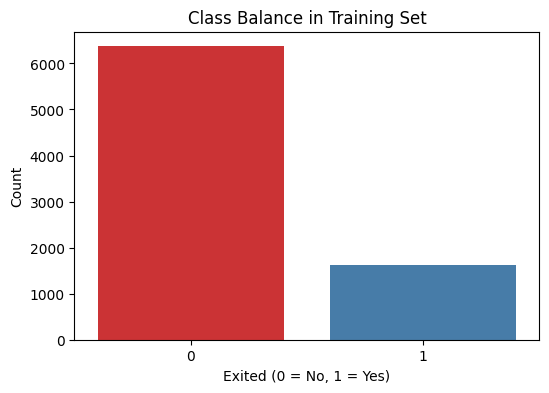

In [14]:
# Check class balance in the training set
class_balance = y_train.value_counts(normalize=True)
print("Class Balance in Training Set:\n", class_balance)
plot_class_balance(y_train)


### Training Model without accounting for class imbalance

In [15]:
# Train a RandomForest model without accounting for class imbalance
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

In [16]:
# Calculate F1 score and AUC-ROC score
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])

# Display classification report, F1 score, and AUC-ROC score
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print(f"F1 Score: {f1}")
print(f"AUC-ROC Score: {auc_roc}")


Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.91      1593
           1       0.75      0.44      0.56       407

    accuracy                           0.86      2000
   macro avg       0.81      0.70      0.74      2000
weighted avg       0.85      0.86      0.84      2000

F1 Score: 0.5572755417956656
AUC-ROC Score: 0.8486313740551028


#### Observation
- Accuracy: 0.86 — The model correctly classified 86% of the cases overall, but this may be inflated by the class imbalance (more customers stayed).
- Macro Avg F1: 0.74 — Reflects the average performance across both classes, showing that class 1 (Exited) drags down the overall score.
- AUC-ROC Score: 0.85 — A strong result, indicating that the model performs well in distinguishing between the two classes across thresholds, despite the lower recall for exited customers.

No handles with labels found to put in legend.


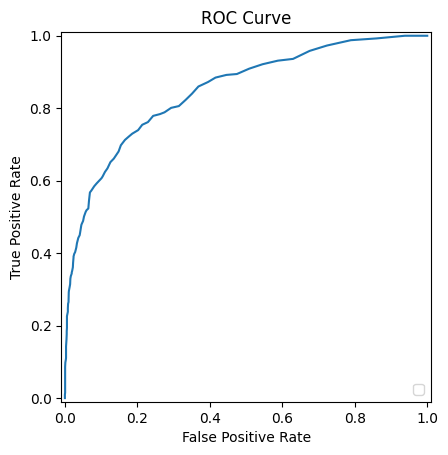

In [17]:
# Plot ROC curve
plot_roc_curve(y_test, rf_model, X_test)

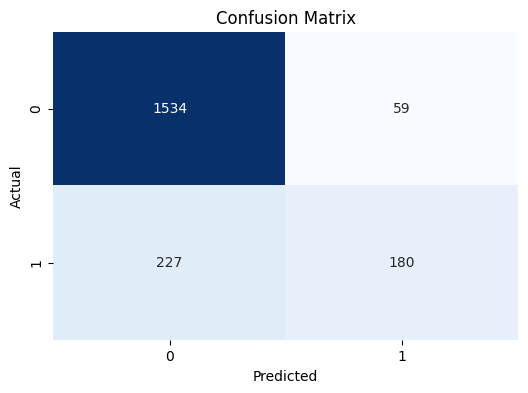

In [18]:
# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

#### Observation

- The high number of false negatives (227) is problematic because the bank's primary goal is to identify customers who are likely to churn. Missing these customers means the bank loses opportunities to retain them. This aligns with the lower recall score of 0.44 for the churn class (Exited = 1).
- AUC-ROC Score: 0.85 — The area under the curve (AUC) is quite high, indicating that the model has a strong ability to separate churners from non-churners. A perfect model would have an AUC of 1, and a random guess would have an AUC of 0.5.
- Shape of the Curve: The ROC curve rises steeply towards the top-left corner, which is a good sign. This shows that the model is effective at maintaining a high true positive rate while keeping the false positive rate low, though there is some room for improvement.

**In summary, while the ROC curve and AUC score show that the model has good discriminatory power, the confusion matrix highlights that improvements are still needed in catching more true churners (reducing the false negatives).**

### Train Model with Regard to Imbalance

#### RandomForest classifier

In [19]:
# Function to evaluate model
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(f"\n{model_name} Results:")
    print(f"F1 Score: {f1}")
    print(f"AUC-ROC Score: {auc_roc}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    return f1, auc_roc


--- Model with Class Weights ---

Class Weights Results:
F1 Score: 0.555205047318612
AUC-ROC Score: 0.851272690255741
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92      1593
           1       0.78      0.43      0.56       407

    accuracy                           0.86      2000
   macro avg       0.82      0.70      0.74      2000
weighted avg       0.85      0.86      0.84      2000



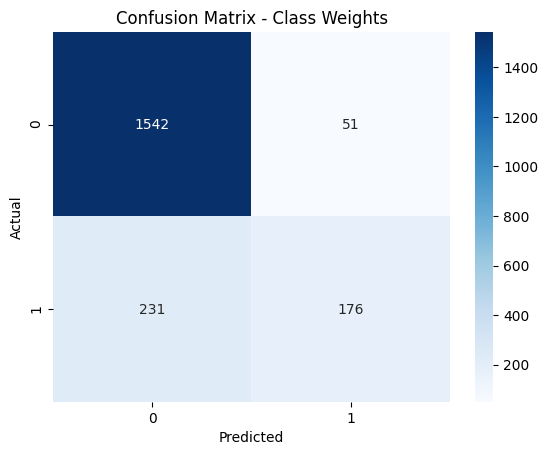

In [20]:
#Baseline Model - Using Class Weights in RandomForest
print("\n--- Model with Class Weights ---")
rf_class_weight = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_class_weight.fit(X_train, y_train)
f1_weight, auc_roc_weight = evaluate_model(rf_class_weight, X_test, y_test, 'Class Weights')



--- Upsampling the Minority Class ---

Upsampled Data Results:
F1 Score: 0.5966850828729282
AUC-ROC Score: 0.8507613931342745
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.91      1593
           1       0.68      0.53      0.60       407

    accuracy                           0.85      2000
   macro avg       0.78      0.73      0.75      2000
weighted avg       0.84      0.85      0.85      2000



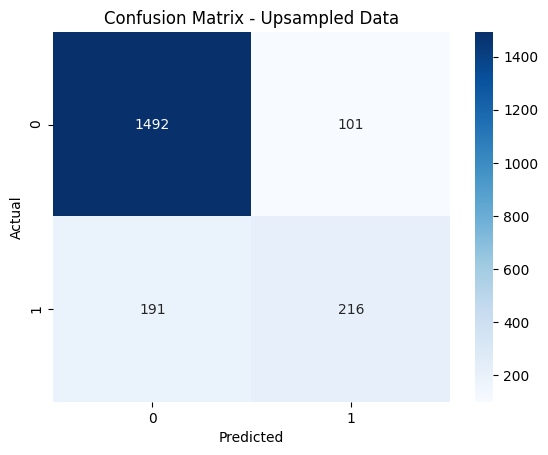

In [21]:
# 2. Upsampling the Minority Class (Class 1)
print("\n--- Upsampling the Minority Class ---")
# Concatenate X_train and y_train for resampling
train_data = pd.concat([X_train, y_train], axis=1)
# Separate the minority and majority classes
minority_class = train_data[train_data['Exited'] == 1]
majority_class = train_data[train_data['Exited'] == 0]
# Upsample minority class
minority_upsampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)
# Combine majority class with upsampled minority class
upsampled_train = pd.concat([majority_class, minority_upsampled])
# Split the upsampled data back into X and y
X_train_upsampled = upsampled_train.drop(columns=['Exited'])
y_train_upsampled = upsampled_train['Exited']
# Train the model
rf_upsampled = RandomForestClassifier(random_state=42)
rf_upsampled.fit(X_train_upsampled, y_train_upsampled)
f1_upsample, auc_roc_upsample = evaluate_model(rf_upsampled, X_test, y_test, 'Upsampled Data')



--- Downsampling the Majority Class ---

Downsampled Data Results:
F1 Score: 0.5786516853932584
AUC-ROC Score: 0.8539248030773454
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.78      0.85      1593
           1       0.47      0.76      0.58       407

    accuracy                           0.78      2000
   macro avg       0.70      0.77      0.71      2000
weighted avg       0.83      0.78      0.79      2000



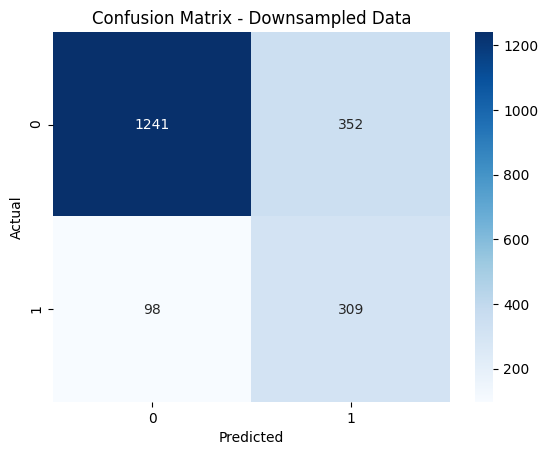

In [22]:
# 3. Downsampling the Majority Class (Class 0)
print("\n--- Downsampling the Majority Class ---")
# Downsample majority class
majority_downsampled = resample(majority_class, replace=False, n_samples=len(minority_class), random_state=42)
# Combine downsampled majority class with minority class
downsampled_train = pd.concat([majority_downsampled, minority_class])
# Split the downsampled data back into X and y
X_train_downsampled = downsampled_train.drop(columns=['Exited'])
y_train_downsampled = downsampled_train['Exited']
# Train the model
rf_downsampled = RandomForestClassifier(random_state=42)
rf_downsampled.fit(X_train_downsampled, y_train_downsampled)
f1_downsample, auc_roc_downsample = evaluate_model(rf_downsampled, X_test, y_test, 'Downsampled Data')


#### Logistic Regression Model

In [23]:
# Logistic Regression model function
def logistic_regression_model(X_train, y_train, X_test, y_test, model_name):
    lr_model = LogisticRegression(random_state=42, max_iter=1000)
    lr_model.fit(X_train, y_train)
    return evaluate_model(lr_model, X_test, y_test, model_name)



--- Logistic Regression with Class Weights ---


/home/jovyan/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression - Class Weights Results:
F1 Score: 0.4858369098712446
AUC-ROC Score: 0.7666032750778513
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.70      0.79      1593
           1       0.37      0.70      0.49       407

    accuracy                           0.70      2000
   macro avg       0.64      0.70      0.64      2000
weighted avg       0.79      0.70      0.73      2000



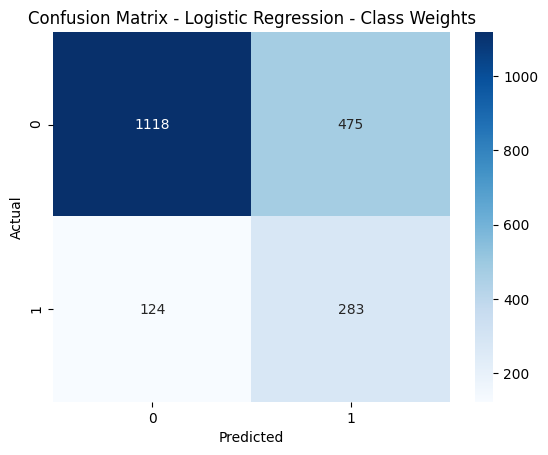

In [24]:
# 1. Logistic Regression with Class Weights
print("\n--- Logistic Regression with Class Weights ---")
lr_class_weight = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
lr_class_weight.fit(X_train, y_train)
f1_lr_weight, auc_roc_lr_weight = evaluate_model(lr_class_weight, X_test, y_test, 'Logistic Regression - Class Weights')



--- Logistic Regression on Upsampled Data ---


/home/jovyan/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression - Upsampled Results:
F1 Score: 0.48588537211291705
AUC-ROC Score: 0.7674361572666658
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.70      0.79      1593
           1       0.37      0.70      0.49       407

    accuracy                           0.70      2000
   macro avg       0.64      0.70      0.64      2000
weighted avg       0.79      0.70      0.73      2000



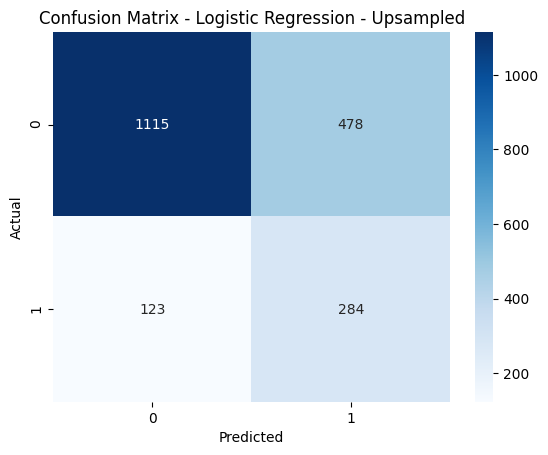

In [25]:
# 2. Logistic Regression on Upsampled Data
print("\n--- Logistic Regression on Upsampled Data ---")
f1_lr_upsample, auc_roc_lr_upsample = logistic_regression_model(X_train_upsampled, y_train_upsampled, X_test, y_test, 'Logistic Regression - Upsampled')



--- Logistic Regression on Downsampled Data ---


/home/jovyan/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression - Downsampled Results:
F1 Score: 0.4831649831649832
AUC-ROC Score: 0.7648866123442393
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.69      0.78      1593
           1       0.37      0.71      0.48       407

    accuracy                           0.69      2000
   macro avg       0.63      0.70      0.63      2000
weighted avg       0.79      0.69      0.72      2000



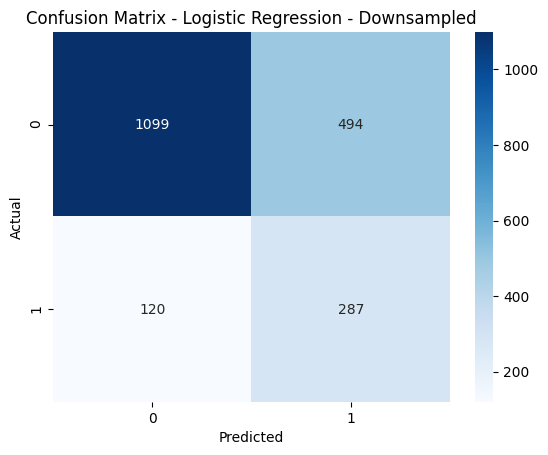

In [26]:
#3. Logistic Regression on Downsampled Data
print("\n--- Logistic Regression on Downsampled Data ---")
f1_lr_downsample, auc_roc_lr_downsample = logistic_regression_model(X_train_downsampled, y_train_downsampled, X_test, y_test, 'Logistic Regression - Downsampled')


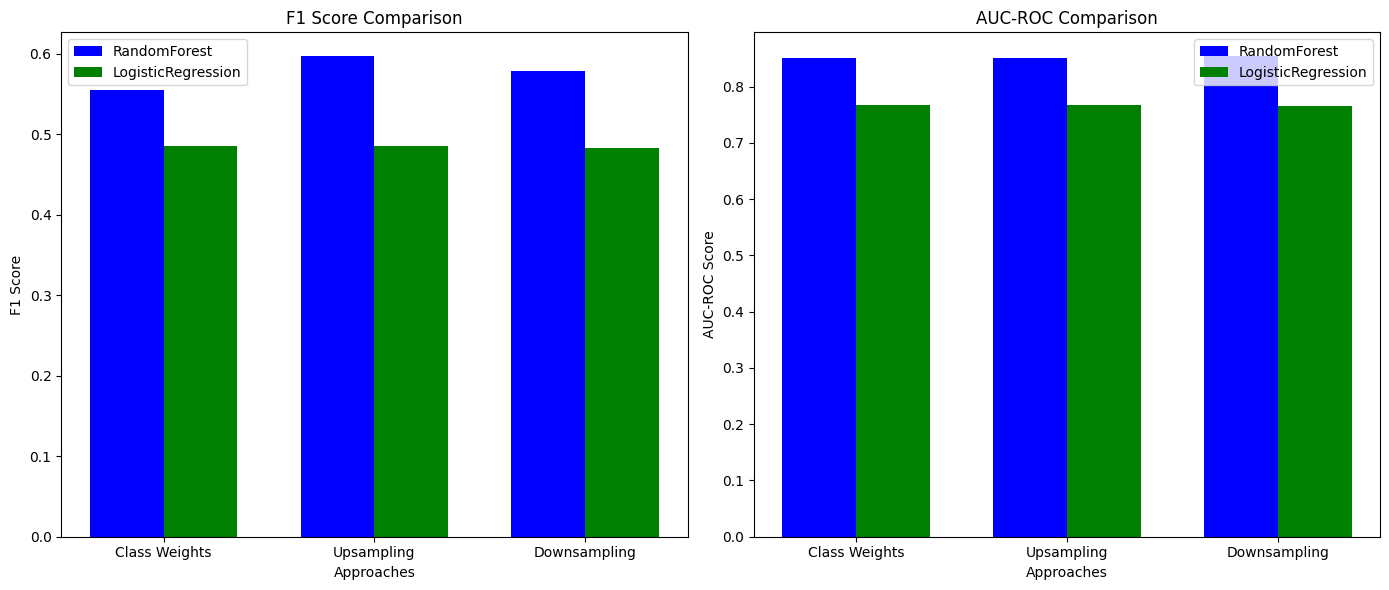

In [27]:
# Plot comparison of F1 scores and AUC-ROC for both RandomForest and Logistic Regression

approaches = ['Class Weights', 'Upsampling', 'Downsampling']

# RandomForest scores
rf_f1_scores = [f1_weight, f1_upsample, f1_downsample]
rf_auc_roc_scores = [auc_roc_weight, auc_roc_upsample, auc_roc_downsample]

# Logistic Regression scores
lr_f1_scores = [f1_lr_weight, f1_lr_upsample, f1_lr_downsample]
lr_auc_roc_scores = [auc_roc_lr_weight, auc_roc_lr_upsample, auc_roc_lr_downsample]

plt.figure(figsize=(14, 6))

# Plot F1 Score comparison
plt.subplot(1, 2, 1)
bar_width = 0.35
index = range(len(approaches))

plt.bar(index, rf_f1_scores, bar_width, label='RandomForest', color='blue')
plt.bar([i + bar_width for i in index], lr_f1_scores, bar_width, label='LogisticRegression', color='green')

plt.title('F1 Score Comparison')
plt.xlabel('Approaches')
plt.ylabel('F1 Score')
plt.xticks([i + bar_width / 2 for i in index], approaches)
plt.legend()

# Plot AUC-ROC Score comparison
plt.subplot(1, 2, 2)
plt.bar(index, rf_auc_roc_scores, bar_width, label='RandomForest', color='blue')
plt.bar([i + bar_width for i in index], lr_auc_roc_scores, bar_width, label='LogisticRegression', color='green')

plt.title('AUC-ROC Comparison')
plt.xlabel('Approaches')
plt.ylabel('AUC-ROC Score')
plt.xticks([i + bar_width / 2 for i in index], approaches)
plt.legend()

plt.tight_layout()
plt.show()

#### Observations

- RandomForest shows a clear advantage over Logistic Regression in both F1 Score and AUC-ROC across all approaches, making it the better choice for this dataset when addressing class imbalance.
- Upsampling tends to give the best results for both models, especially in terms of F1 Score and AUC-ROC.

### Final Test

In [28]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a pipeline with upsampling and RandomForestClassifier
pipeline = Pipeline([
    ('oversample', RandomOverSampler(random_state=42)),  # Apply RandomOverSampler
    ('classifier', RandomForestClassifier(random_state=42))  # Apply RandomForest
])

# Define the hyperparameter grid to tune
param_grid = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

In [ ]:
# Set up the GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Fit the model to the upsampled training data
grid_search.fit(X_train, y_train)

# Best hyperparameters after tuning
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

In [ ]:
# Predict on the test data using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and display F1 score, AUC-ROC, and classification report
f1_final = f1_score(y_test, y_pred)
auc_roc_final = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

print("\nFinal Classification Report:\n", classification_report(y_test, y_pred))
print(f"Final F1 Score: {f1_final:.4f}")
print(f"Final AUC-ROC Score: {auc_roc_final:.4f}")

### Conclusion

In the task for creating a model capable of predicting Beta Bank customer churn with an f1 score of at least 0.59, Random Forrest Classifier and Logistic Regression were tested using three different target class balancing methods ('weight_class'='balanced' argument, upsampling, and downsampling). 
 
The best Machine Learning algorithm was the Random Forrest Classifier.

Final F1 Score: 0.6225
Final AUC-ROC Score: 0.8600

After the changes, it takes forever to run the code online here but when I ran it loccaly. These are the results.

Best hyperparameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}

Final Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      1607
           1       0.60      0.65      0.62       393

    accuracy                           0.85      2000
   macro avg       0.76      0.77      0.76      2000
weighted avg       0.85      0.85      0.85      2000

Final F1 Score: 0.6225
Final AUC-ROC Score: 0.8600